# Implementation of the YOLO model


This is an implementation of the powerful YOLO model used for object detection in images.
Many of the ideas in this notebook are described in the two YOLO papers: Redmon et al., 2016 (https://arxiv.org/abs/1506.02640) and Redmon and Farhadi, 2016 (https://arxiv.org/abs/1612.08242). 

In [35]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io

import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
import imageio
%matplotlib inline

## YOLO Model

Images are collected while driving a car and taking photographs every few seconds. Bounding boxes are drawn around the objects or classes that we want our algorithm to detect.


The **input** is a batch of images of shape (m, 608, 608, 3).

The **output** is a list of bounding boxes along with the recognized classes. 

Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ where
$p_c$ is the probability that there is an object lying in the box. $b_x$ and $b_y$ are the midpoints of the box while 
$b_h$ and $b_w$ are the height and width of the box. $b_x$, $b_y$, $b_h$ and $b_w$ lie between 0 and 1 with 0 as the upper-left corner of the cell and 1 at the bottom-right corner of the cell.

$c$ is the object class ranging from 1 to 80 or it can be expanded as a 80-dimensional one-hot vector.

We will use 5 anchor boxes. So you can think of the YOLO architecture as the following: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).

So we reduce a 608 by 608 pixel image to a 19 by 19 grid with a reduction factor of 32. It's as if we ran a CNN using 32 by 32 sliding window on the 608 by 608 image and obtained a 19 by 19 (= 608/32) grid of cells and stored the output of each sliding window CNN operation separately in each of these cells.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

We have gathered the information about the 80 classes and 5 boxes in two files "coco_classes.txt" and "yolo_anchors.txt".
The information about anchor boxes is in the format of width and height and not in the $b_x$, $b_y$, $b_h$ and $b_w$ format. They need to be converted to this format first. Also, the test image might have different dimensions which we need to pre-process into 608x608 images. 


In [36]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
#image_shape = (357., 635.) 

Lets load a pre-trained yolo model.These weights come from the official YOLO website, and were converted using a function written by Allan Zelener. References are at the end of this notebook. Technically, these are the parameters from the "YOLOv2" model, but we will more simply refer to it as "YOLO" in this notebook.

In [9]:
yolo_model = load_model("model_data/yolo.h5")

C:\Users\Akshay\Anaconda3\lib\site-packages\keras\engine\saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Heres a summary of our yolo model.

In [10]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

As previously mentioned, the anchors provided are in terms of box width and height and need to be converted to tensors of 
$b_x$, $b_y$, $b_h$ and $b_w$. We'll do that below.

The code below returns the following

$b_x$, $b_y$,
$b_h$ and $b_w$
    
box_confidence :  Probability estimate for whether each box contains any object $(p_c)$.
    
box_class_probs : Probability distribution estimate for each box over class labels $c_i$.
    
    

In [42]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

## Filtering

Since there will be 5 boxes per cell and so 19 x 19 X 5 boxes total in the grid, we need to filter out the boxes with low probability of detecting a class in each cell and then get rid of the boxes from multiple cells that overlap. Thus reducing to the most probable unique boxes. We therefore need to perform filtering in two stages as below,

Two stages of filtering:
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class)
  
  Filtering with a threshold.
  
  
- Select only one box when several boxes overlap with each other and detect the same object
  
  Non-max suppression of overlapping boxes.

In [38]:
def filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
   
    
    #  Compute box scores
    box_scores = box_confidence * box_class_probs
    
    #  Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    box_classes = K.argmax(box_scores, axis = -1)
    box_class_scores = K.max(box_scores, axis = -1)
    
    
    
    filtering_mask = box_class_scores >= threshold
    
    # Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

## Non-max suppression ###

Even after filtering by thresholding over the classes scores, we still end up with a lot of overlapping boxes. For that, we use Non-max suppression (NMS).

In [39]:
def non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
   
    # nms_indices is the list of indices of the best boxes
    
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold )
    
    # collect scores, boxes and classes corresponding to the list of nms_indices
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [64]:
def final_filter(yolo_outputs, image_shape , max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, 
    box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.)
                    (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], 
                    then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    # Convert boxes to be ready for filtering functions.
    # converts the yolo box coordinates (x,y,w,h) to box corners' coordinates (x1, y1, x2, y2) 
    # to fit the input of yolo_filter_boxes.
        
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    # Filter box for best in a cell

    scores, boxes, classes = filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)
    
    # Filter boxes for overlapping

    scores, boxes, classes = non_max_suppression(scores, boxes, classes, max_boxes , iou_threshold)
    
    
    return scores, boxes, classes

In [78]:
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """
    
    scores, boxes, classes = final_filter(yolo_outputs, image_shape)
    
    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    
    out_scores, out_boxes, out_classes = sess.run( [scores, boxes, classes] , 
                                                  feed_dict = {yolo_model.input: image_data, K.learning_phase(): 0})

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image = imageio.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Lets run the model on the "test.jpg" image to verify that our function is correct.

## Try out on a new image

In [69]:
sess = K.get_session()

Found 7 boxes for test.jpg
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


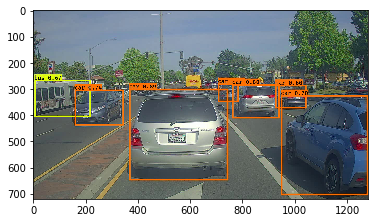

In [82]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_file = "test.jpg"
imshape= (imageio.imread("images/" + image_file).shape[0:2])      
image_shape = ( float(imshape[0]), float(imshape[1]))

out_scores, out_boxes, out_classes = predict(sess, image_file)

Found 10 boxes for jt.jpg
bicycle 0.62 (440, 165) (510, 270)
bicycle 0.65 (64, 160) (371, 352)
person 0.67 (137, 54) (297, 303)
person 0.71 (0, 8) (45, 273)
person 0.72 (42, 3) (187, 283)
person 0.72 (549, 61) (630, 291)
bicycle 0.73 (364, 156) (491, 285)
person 0.75 (384, 54) (475, 296)
person 0.76 (481, 40) (568, 287)
person 0.79 (312, 67) (386, 215)


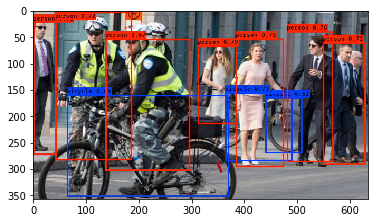

In [85]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_file = "jt.jpg"
imshape= (imageio.imread("images/" + image_file).shape[0:2])      
image_shape = ( float(imshape[0]), float(imshape[1]))

out_scores, out_boxes, out_classes = predict(sess, image_file)

**References**: The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's github repository. The pretrained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 